# Notebook 2

Focusing on analysis calculated for the whole genome, then zoomed in to our region of interest.

## Nucleotide diversity

For each chromosome, need to be done only once:

```bash
filtered=/users/c/p/cpetak/EG2023/structural_variation/filtered_bcf_files/NW_022145594.1
# spack load vcftools@0.1.14
vcftools --vcf $filtered/NW_022145594.1_filtered.vcf --site-pi --out NW_022145594.1_nuc_div
```

Output: Pi nucleotide diversity for each site.

`vcftools --vcf ${filtered}/NW_022145594.1_filtered.vcf --window-pi 10000 --out NW_022145594.1_nuc_div` 

Output: Pi average over windows.

<img src="2024-07-12-10-31-57.png" width="800">

`vcftools --vcf ${filtered}/NW_022145594.1_filtered.vcf --TajimaD 10000 --out NW_022145594.1_nuc_div`

Output: Tajima's D over windows.

"A positive Tajima's D signifies low levels of both low and high frequency polymorphisms, indicating a **decrease in population size and/or balancing selection**."

"A negative Tajima's D signifies an excess of low frequency polymorphisms relative to expectation, indicating **population size expansion** (e.g., after a bottleneck or a selective sweep).

<img src="2024-07-12-10-39-44.png" width="800">

### Zoom in and plot homozygotes only and q and p separately



Region: 12.702.886-16.793.794, expanded by 100,000 both ends -> 12.602.886 - 16.893.794. (12602886 16893794)

1. Subset vcf to extended region of interest, like in Notebook 1. 

2. Get only homozygotes to one orientation:

```bash
#spack load bcftools@1.10.2
bcftools view -S NW_022145594.1_12702886_16793794_vcf_list_homop -o NW_022145594.1_12602886_16893794_homop.vcf NW_022145594.1_12602886_16893794.vcf
bcftools view -S NW_022145594.1_12702886_16793794_vcf_list_homoq -o NW_022145594.1_12602886_16893794_homoq.vcf NW_022145594.1_12602886_16893794.vcf
```
```bash
chr="NW_022145594.1" start=12702886 stop=16793794
myfolder=~/EG2023/structural_variation/filtered_bcf_files/${chr}
bcftools view -S ${chr}_${start}_${stop}_vcf_list_homop -o ${chr}_${start}_${stop}_homop.vcf ${myfolder}/${chr}_filtered.vcf
bcftools view -S ${chr}_${start}_${stop}_vcf_list_homoq -o ${chr}_${start}_${stop}_homoq.vcf ${myfolder}/${chr}_filtered.vcf
```

3. Calculate nucleotide diversity like above, smaller window size.

```bash
vcftools --vcf ${chr}_${start}_${stop}_homop.vcf --window-pi 100 --out ${chr}_${start}_${stop}_nuc_div_homop
vcftools --vcf ${chr}_${start}_${stop}_homoq.vcf --window-pi 100 --out ${chr}_${start}_${stop}_nuc_div_homoq

vcftools --vcf ${chr}_${start}_${stop}_homop.vcf --TajimaD 100 --out ${chr}_${start}_${stop}_nuc_div_homop
vcftools --vcf ${chr}_${start}_${stop}_homoq.vcf --TajimaD 100 --out ${chr}_${start}_${stop}_nuc_div_homoq
```

Adding 100,000 was not enough, doing same as above but with whole chromosome instead.

```bash
bcftools view -S NW_022145594.1_12702886_16793794_vcf_list_homop -o NW_022145594.1_homop.vcf ${filtered}/NW_022145594.1_filtered.vcf
bcftools view -S NW_022145594.1_12702886_16793794_vcf_list_homoq -o NW_022145594.1_homoq.vcf ${filtered}/NW_022145594.1_filtered.vcf
vcftools --vcf NW_022145594.1_homop.vcf --window-pi 10000 --out NW_022145594.1_nuc_div_homop
vcftools --vcf NW_022145594.1_homoq.vcf --window-pi 10000 --out NW_022145594.1_nuc_div_homoq
vcftools --vcf NW_022145594.1_homoq.vcf --TajimaD 10000 --out NW_022145594.1_nuc_div_homoq
vcftools --vcf NW_022145594.1_homop.vcf --TajimaD 10000 --out NW_022145594.1_nuc_div_homop
```

```python
plt.figure(figsize=(15, 5))
plt.plot(dfp["BIN_START"],dfp["TajimaD"],color="blue",label="p",alpha=0.5)
plt.plot(dfq["BIN_START"],dfq["TajimaD"],color="orange",label="q",alpha=0.5)
plt.axvline(12702886, color="red")
plt.axvline(16793794, color="red")
plt.axhline(0, color="black")
plt.xlabel("Position")
plt.ylabel("Tajima's D")
plt.title("Window size 10,000")
offset=3_000_000
plt.xlim(12702886-offset,16793794+offset)
plt.legend()
plt.show()
```

<img src="2024-07-12-11-15-03.png" width="800"><br>
<img src="2024-07-12-11-17-09.png" width="800">

Same but with points

<img src="2024-07-12-11-19-34.png" width="800">

## Linkage disequilibrium

### Step 1: Chromosome vcf file to gds

conda activate grn
Run:
`Rscript vcf2gds.R ${filtered}/NW_022145594.1_filtered.vcf NW_022145594.1`,
same script from before (in Notebook 1), makes gds file

### Step 2: Calculate LD with a certain window size

To check how many windows a specific window size will produce run [LD_get_num_windows.R](https://github.com/Cpetak/local_pca_pipe/blob/main/LD_get_num_windows.R).

`Rscript LD_get_num_windows.R NW_022145594.1.gds 50000`

***NOTE:*** Around 1,000 windows is good. Too big window size could break the code if there are less than 1 windows, but too small window size will take literally ages to compute!

In our case, with 50_000 bp we get 1061 windows.

`mkdir makegrid_NW_022145594.1_50000` this is where the small temporary files will be saved. Run [makegrid_launcer.sh](https://github.com/Cpetak/local_pca_pipe/blob/main/makegrid_launcher.sh) which creates a job array that runs [makegrid.R](https://github.com/Cpetak/local_pca_pipe/blob/main/makegrid.R).

run: `sbatch makegrid_launcher.sh ~/WGS/inversion_results/NW_022145594.1.gds 50000`, file name, window size, submits 200 jobs in the short partition. Output is 200 files, each containing a subset of the windows.

### Step 3: Put together the set of files

Run [gather_results.R](https://github.com/Cpetak/local_pca_pipe/blob/main/gather_results.R), `Rscript gather_results.R NW_022145594.1 50000` , output is combined_chrom_windowsize.Rdata

Free up space: `rm -r makegrid_NW_022145594.1_50000`

### Step 4: Make triangle plot

Run [plot_LD.R](https://github.com/Cpetak/local_pca_pipe/blob/main/plot_LD.R), `Rscript plot_LD.R NW_022145594.1 50000`, output is a pdf.

<img src="2024-07-13-16-27-08.png" width="400"><br>
With old filtering:<br>
<img src="2024-07-13-16-30-04.png" width="400">

## Triangle plot for specific region

For zooming in a specific region, repeat above but with a subsetted vcf

***NOTE:*** Above code can be used that same but file names only include chromosome and LD window size so make sure to move output figures to avoid overwriting them!

For region 12702886 - 16793794 plus padding: 8702886 - 20793794. 

`Rscript ../local_pca_pipe/LD_get_num_windows.R NW_022145594.1_8702886_20793794.gds 10000`
-> 1208

Repeated above steps:

<img src="2024-07-13-17-05-55.png" width="400"><br>

If you zoom in, you can see what you should be seeing, below with old filtering but more visible: <br>

<img src="2024-07-13-17-08-00.png" width="400">

## U-plot:

For the U-plot, I calculated the LD for each pair of SNPs, in the 12702886 - 16793794 range, only keeping r2>0.6 to reduce the file size.

```bash
sed 's/_//g' NW_022145594.1_12702886_16793794.vcf > ld_input_NW_022145594.1_12702886_16793794.vcf
./plink --vcf ld_input_NW_022145594.1_12702886_16793794.vcf --recode --allow-extra-chr --out NW_022145594.1_12702886_16793794_plink
./plink --file NW_022145594.1_12702886_16793794_plink --make-bed --allow-extra-chr --out NW_022145594.1_12702886_16793794_afterQC
./plink --bfile NW_022145594.1_12702886_16793794_afterQC --r2 --allow-extra-chr --ld-window-r2 0.6 --ld-window 100000000 --ld-window-kb 100000000 --out NW_022145594.1_12702886_16793794_resultLD
```

Note:
```bash
--ld-window 10 #compare 2 SNPS only if they are within 10 SNPS apart
--ld-window-kb 1000 #compare 2 SNPS only if they are within 1.000.000 bp apart (both needs to be true)
--ld-window-r2 0 #output any LD value, regardless of what it is. default would be 0.2, so only values that are above 0.2 are written to file
```

Output: r2 value for 11,378 SNP comparisions.

<img src="2024-07-13-16-13-48.png" width="600">

<img src="2024-08-12-10-34-52.png" width="600">

Note: plots are combing from random_quick_plotting.ipynb colab notebook. 

## Coverage

### Step 1

A) Make a file called myposi.bed with one line in it: `NW_022145594.1 15422748 16793794`, chromosome, start, stop of region to get coverage for.

B) Make a file called bam_list: `/netfiles/pespenilab_share/urchin_bams/BOD_18170X61_200925_A00421_0244_AHKML5DSXY_S81_L002_R1_001.rmdup.bam`, etc, listing all bam files.

C) Make 3 files: hetero_list_cov, homop_list_cov, homoq_list_cov, listing names of coverage files for each group.

### Step 2

Calculate coverage for each individual, for that specific region.

```bash
while read line ; do
        echo "$line"
        FILE=$(mktemp)
        pos_file='~/WGS/local_pca_pipe/myposi.bed'
        cat header.txt >> $FILE
        echo "spack load samtools@1.10" >> $FILE
        out_name=$(cut -d '.' -f1 <<< $line)
        out_name2=$(echo "$out_name" | cut -d'/' -f5)
        echo "samtools depth -b $pos_file $line > ~/WGS/inversion_results/${out_name2}.coverage" >> $FILE
        sbatch $FILE
        #cat $FILE
        sleep 0.1
        rm $FILE
done < $1
```
Run: `bash cov_launcher.sh bam_list`

First for: 12702886 - 13424367, then for: 15422748 - 16793794.

### Step 3

Move .coverage files in the 2 folders: left_bp (breakpoint area), right_bp.

Run: `python coverage_plotting.py`, [coverage_plotting.py](https://github.com/Cpetak/local_pca_pipe/blob/main/coverage_plotting.py)

Red line = high linkage outlier

Homop: 

<img src="2024-08-12-10-18-00.png" width="800">

Hetero:

<img src="2024-08-12-10-18-26.png" width="800">

Homoq:

<img src="2024-08-12-10-18-48.png" width="800">

Boxplot for specific region (blue line borders):

<img src="2024-08-12-10-16-37.png" width="500">



p<0.0001 3-way nonparametric test

Homop: 

<img src="2024-08-12-10-43-15.png" width="800">


Hetero:

<img src="2024-08-12-10-42-59.png" width="800">

Homoq:

<img src="2024-08-12-10-42-41.png" width="800">

Boxplot for specific region (blue line borders):

<img src="2024-08-12-10-43-34.png" width="500">

## Inversion markers

Looked through the entire chromosome to find SNPs where all homoq are homozygous and have the same allele, the same for homop, then look for loci where these SNPs are different between the two. 
Found 12 such loci, all between 12.772.520 and 12.774.224 (in left breakpoint region), a 1704 bp region!
The p always has the ref, the q always has the alt. 

Then, checked whether other random regions of the chromosome are more or less heterozygous than the left breakpoint region in either only homozygotes to the standard, homozygotes to the inversion, and heterozygotes. So, for example, given all the heterozygote individuals and given N randomly drawn regions, what is the portion of N that is less heterozygous for each individual? We expect this value to be high, since the region of interest should be quit heterozygous. Similary, given all the homozygous individuals to the standard orientation and given N randomly drawn regions, what is the portion of N that is less heterozygous for each individual? We expect this value to be low, since most randomly drawn regions should have a higher heterozygosity. See two figures below.

Run: `python find_markers.py 1000 hetero 0`, [find_markers.py](https://github.com/Cpetak/local_pca_pipe/blob/main/find_markers.py)

Arguments: \
num_rand, type=int, "Number of times to randomly sample" \
cat, type=str, "Genotype to compare to, homop, homoq or hetero" \
calc_markers, type=bool, "Whether or not to calculate 12 markers (0 no, 1 yes)" 

<img src="2024-08-14-08-57-58.png" width="250"> \
Genomic position | nucleotide shared by all homozygotes to the inversion | nucleotide shared by all homozygotes to the inversion | reference in the assembly

Heterzygotes, 1000 random draws: \
<img src="2024-08-14-09-29-47.png" width="400"> \
As expected, for most heterozygous individuals (~50/82) the left breakpoint region has higher heterozygosity than any of the 1000 other random regions of the same length. For every individual more than 50% of the randomly sampled regions had a lower heterozygosity than the left breakpoint.

Homozygous individuals to the standard orientation, 1000 random draws: \
<img src="2024-08-14-09-40-28.png" width="400"> \
For most homozygous individuals to the standard orientation, the left breakpoint region is less heterozygous than most of the 1000 randomly selected region.

Homozygous individuals to the inverted orientation, 1000 random draws: \
<img src="2024-08-21-10-19-47.png" width="400">

# GO Enrichment for a specific region

### Step 1 - List of GO terms
Uniprot has GO terms associated to each gene in the urchin genome, here is the link to retrieve that info: https://www.ebi.ac.uk/QuickGO/annotations?taxonId=7668&taxonUsage=exact. 

Used this code to transform uniprot - GO output file into the mapping file topGO expects:

```bash
awk -F "\t" '{print $2"\t"$5}' QuickGO-annotations-1642716310981-20220120.tsv > temp_mapping
sed '$!N; /^\(.*\)\n\1$/!P; D' temp_mapping > temp2_mapping # It deletes duplicate, consecutive lines from a file
awk 'BEGIN{FS="\t"} {for(i=2; i<=NF; i++) { if (!a[$1]) a[$1]=$1FS$i ;else a[$1]=a[$1]","$i};if ($1 != old) b[j++] = a[old];old=$1 } END{for (i=0; i<j; i++) print b[i] }' temp2_mapping > GO_mapping_topGO #it collapses repeated lines into 1, comma separated, output file is in this git repo
```

### Step 2 - List of LOC to Uniprot IDs
Downloaded the gff file from the NCBI genome assembly Spur_5.0 https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000002235.5/

Processed file with:

`grep -o 'gene=LOC[0-9]\+' genomic.gff | sed 's/;.*//' | awk -F= '{print $2}' > all_locs_gff`

`sed '$!N; /^\(.*\)\n\1$/!P; D' all_locs_gff > all_locs_gff2`

To get the list of genes (LOC). 32,087 genes.

Uploaded these LOC gene names to https://www.uniprot.org/uploadlists/ From Ensemble Genomes To uniprot. Downloaded results in tsv format. 3 columns: LOC id, uniprot id, uniprot id \_STRPU. Since a LOC id can map to more than 1 uniprot ids, I used the following code to select a specific uniprot id for each LOC to avoid biasing the GO analysis: 

Run: `python loc2uniprot.py`, [loc2uniprot.py](https://github.com/Cpetak/local_pca_pipe/blob/main/loc2uniprot.py)

Output: all_locs_to_uniprotIDs.txt Note: to use, needed to sort file using the `sort all_locs_to_uniprotIDs.txt` command.

### Step 3 - Get list of interesting LOCs and Uniprot IDs
To get the list of genes that are of interest from the NCBI annotation file (Run bash GO_from_region.sh NW_022145594.1 12702886 13424367):

```bash
chr=$1
start=$2
stop=$3

#Most inclusive, includes genes that start before the end of the region (stop) and ends after the start of the region (start). So, it includes genes that span the entire region, the genes that start before the start of the region and end somewhere in the middle, genes that start somewhere in the middle and end outside of the region, and genes that are entirely included.
awk -v mychr=$chr '$1 == mychr' ~/WGS/local_pca_pipe/supp_files/genomic.gff | awk -v mystart=$start '$5 >= mystart {print}' | awk -v mystop=$stop '$4 <= mystop {print}' | awk -v myname='gene' '$3 == myname {print}' | grep -o 'gene=LOC[0-9]\+' | awk -F= '{print $2}' | sort | uniq > ${1}_${2}_${3}_locs1.txt

#More conservative, subset of the first locs list. Only includes genes that start and end within the region.
awk -v mychr=$chr '$1 == mychr' ~/WGS/local_pca_pipe/supp_files/genomic.gff | awk -v mystart=$start '$4 >= mystart {print}' | awk -v mystop=$stop '$5 <= mystop {print}' | awk -v myname='gene' '$3 == myname {print}' | grep -o 'gene=LOC[0-9]\+' | awk -F= '{print $2}' | sort | uniq > ${1}_${2}_${3}_locs2.txt

#Only includes genes that start before the start and end after the start. Includes genes that span entire region. It is a subset of the first locs list. The point is that it lists genes the left breakpoint disrupts.
awk -v mychr=$chr '$1 == mychr' ~/WGS/local_pca_pipe/supp_files/genomic.gff | awk -v mystart=$start '$5 >= mystart {print}' | awk -v mystart=$start '$4 <= mystart {print}' | awk -v myname='gene' '$3 == myname {print}' | grep -o 'gene=LOC[0-9]\+' | awk -F= '{print $2}' | sort | uniq > ${1}_${2}_${3}_locs3_1.txt

#Only includes genes that start before the end and end after the end. Includes genes that span entire region. It is a subset of the first locs list. The point is that it lists genes the right breakpoint disrupts.
awk -v mychr=$chr '$1 == mychr' ~/WGS/local_pca_pipe/supp_files/genomic.gff | awk -v mystop=$stop '$5 >= mystop {print}' | awk -v mystop=$stop '$4 <= mystop {print}' | awk -v myname='gene' '$3 == myname {print}' | grep -o 'gene=LOC[0-9]\+' | awk -F= '{print $2}' | sort | uniq > ${1}_${2}_${3}_locs3_2.txt

#Subset of first locs list, doesn't include genes that are inside the region, not crossing the breakpoints (second locs list). So this set is A - B, where A is all the genes (first locs list), B is only genes in the middle of the region (second locs list)
cat ${1}_${2}_${3}_locs3_1.txt ${1}_${2}_${3}_locs3_2.txt | sort | uniq > ${1}_${2}_${3}_locs3.txt
```
Output: list of gene names (LOC)

Yellow: genes that are included in the lists above.

<img src="2024-08-21-12-25-15.png" width="400">

Then, to turn LOCS into Uniprot IDs:
```bash
join -t, -1 1 -2 1 -o 1.1,2.2 ${1}_${2}_${3}_locs1.txt ~/WGS/local_pca_pipe/supp_files/all_locs_to_uniprotIDs.txt | awk -F, '{print $2}' > ${1}_${2}_${3}_uniprot1.txt
join -t, -1 1 -2 1 -o 1.1,2.2 ${1}_${2}_${3}_locs2.txt ~/WGS/local_pca_pipe/supp_files/all_locs_to_uniprotIDs.txt | awk -F, '{print $2}' > ${1}_${2}_${3}_uniprot2.txt
join -t, -1 1 -2 1 -o 1.1,2.2 ${1}_${2}_${3}_locs3.txt ~/WGS/local_pca_pipe/supp_files/all_locs_to_uniprotIDs.txt | awk -F, '{print $2}' > ${1}_${2}_${3}_uniprot3.txt
```

### Step 4 - Run GO
Run: `Rscript go_enrichment.R NW_022145594.1 12702886 13424367` (has to be the same inputs as for above steps), [go_enrichment.R](https://github.com/Cpetak/local_pca_pipe/blob/main/go_enrichment.R)

Does GO enrichment for all three kinds of categories listed above for all three kids of GO (biological process, cellular component, molecular function) which are combined into one file. So 3 output files in total.

### Results

**NW_022145594.1_12702886_13424367**

13 genes in the least constrained gene list. 1 gene spanning the left end, 1 gene spanning the right end. No significant enrichment.

**NW_022145594.1_15422748_16793794**

29 genes in the least constrained gene list. No genes at the ends. Significant enrichment.

Columns: GO.ID | Term | Annotated | Significant | Expected | P-val

<img src="2024-08-21-13-42-29.png" width="700">

**NW_022145594.1_12702886_16793794**

72 genes in the least constrained gene list. 1 gene spanning the left end, 0 gene spanning the right end. Significant enrichment.

Columns: GO.ID | Term | Annotated | Significant | Expected | P-val

<img src="2024-08-21-13-37-37.png" width="700">

looks like maybe early development genes? \
the larval heart development protein: A0A7M7HPJ4. Weak annotation score, not expressed in early dev on Echinobase. \
1 gene spanning left end: LOC105438675. trichohyalin-like. not expressed early dev. low annotation score. \

anything near the beakpoints (not overlapping necesseraly)? \
LEFT: \
LOC115917770, snRNA, - strand, so start is 12668534, 34,352 bp upstream. \
LOC100890665, orexin receptor type 1. not expressed early dev. low annotation score. 9,794 bp downstream. \
<img src="2024-08-21-14-03-28.png" width="400">

RIGHT: \
LOC584666, probable G-protein coupled receptor 21. not expressed early dev. low annotation score. 9,629 downstream. \
LOC115921256, craniofacial development protein 2-like, - strand, so start is at 16762684, 31,110 bp upstream. not expressed early dev. low annotation score. \
<img src="2024-08-21-14-09-46.png" width="400">

# SNPeff

https://pcingola.github.io/SnpEff/snpeff/introduction/

Downloaded package and tested on example: `java -Xmx8g -jar snpEff.jar -v GRCh37.75 examples/test.chr22.vcf > test.chr22.ann.vcf`

Worked as intended.

Downloaded NW_022145594.1_filtered.vcf from `/users/c/p/cpetak/EG2023/structural_variation/filtered_bcf_files/NW_022145594.1`.

Run:

`java -Xmx8g -jar snpEff.jar -v Strongylocentrotus_purpuratus examples/NW_022145594.1_filtered.vcf > 594_test.vcf`

This successfully downloaded the Strongylocentrotus_purpuratus database SNPeff has had already. Knew the name from running: `java -jar snpEff.jar databases`.
Got an error because the chromosome names in the SNPeff database were different from mine so NW_022145594.1 was not found.
In the output text, it listed all its chromosome names and their corresponding lenghts, so I just looked up the length of NW_022145594.1 from the NCBI assembly page and search for that in the list. AAGJ06000001.1 has exactly the same number of basepairs, 53101916.

597 - 34141700 - AAGJ06000012.1
600 - 37282239 - AAGJ06000015.1
601 - 35007347 - AAGJ06000016.1
603 - 34285068 - AAGJ06000018.1
606 - 52437917 - AAGJ06000020.1
609 - 39838600 - AAGJ06000003.1
610 - 35917773 - AAGJ06000004.1

So replaced the chromosome name and run:

```bash
sed 's/NW_022145594.1/AAGJ06000001.1/g' examples/NW_022145594.1_filtered.vcf > examples/NW_022145594.1_filtered_renamed.vcf
java -Xmx8g -jar snpEff.jar -v Strongylocentrotus_purpuratus examples/NW_022145594.1_filtered_renamed.vcf > 594_test.vcf
```

Output:
- snpEff_summary.html
- snpEff_genes.txt - table of genes and the variant effects
- 594_test.vcf - additional column in the vcf file, shows the effect of the mutation

Repeat with vcf file from only the inversion:
cname=594
(all `java -Xmx8g -jar snpEff.jar -v Strongylocentrotus_purpuratus ${chr}_filtered_renamed.vcf > ${cname}_snpeff.vcf`,
`mv snpEff_summary.html ${cname}_snpEff_summary.html`,
`bash get_html_vals.sh ${cname}_snpEff_summary.html ${cname}.csv`)

`bash subset_vcf.sh $chr $actustart $actustop`
cname=594_inv
`java -Xmx8g -jar snpEff.jar -v Strongylocentrotus_purpuratus ${chr}_${actustart}_${actustop}.vcf > ${cname}_snpeff.vcf`
`mv snpEff_summary.html ${cname}_snpEff_summary.html`
`bash get_html_vals.sh ${cname}_snpEff_summary.html ${cname}.csv`

Allele frequencies:
cname=594
`bcftools view -i 'ANN[*] ~ "HIGH"' ${cname}_snpeff.vcf > high_${cname}_snpeff.vcf`
`vcftools --vcf high_${cname}_snpeff.vcf --freq --out high_${cname}_snpeff_freq.txt`
`bcftools view -i 'ANN[*] ~ "LOW"' ${cname}_snpeff.vcf > low_${cname}_snpeff.vcf`
`vcftools --vcf low_${cname}_snpeff.vcf --freq --out low_${cname}_snpeff_freq.txt`
`bcftools view -i 'ANN[*] ~ "MODERATE"' ${cname}_snpeff.vcf > mod_${cname}_snpeff.vcf`
`vcftools --vcf mod_${cname}_snpeff.vcf --freq --out mod_${cname}_snpeff_freq.txt`
repeat with cname=594_inv

**All of the above gathered in get_snpeff_results.sh. Outputs analysed in snpeff.ipynb.**

### Results

Total chromosome: Variant: 402,500 High impact: 384
Inversion only: Variant: 9,500 High impact: 15

Total variants rate: 131 (total number of basepairs / number of SNPs), so there is a SNP every 131 bps

Inversion variants rate: 5589 (total number of basepairs / number of SNPs), so there is a SNP every 5589 bps, less SNPs, less variation, like in previous plots

Total Missense / Silent ratio: 0.6263 -----> more silent, so no amino acid change

Inversion Missense / Silent ratio: 1.682 -----> more missense, so amino acid change

In [ ]:
#grep '<td class="numeric" bgcolor="[^"]*">[^<]*</td>' 594_snpEff_summary.html | sed -n '1p' | sed -n 's/.*bgcolor="[^"]*">\s*\([^<]*\)\s*<\/td>/\1/p'
#grep '<td class="numeric" bgcolor="[^"]*">[^<]*</td>' 594_snpEff_summary.html | sed -n '11p' | sed -n 's/.*bgcolor="[^"]*">\s*\([^<]*\)\s*<\/td>/\1/p'
#grep '<td class="numeric" bgcolor="[^"]*">[^<]*</td>' 594_snpEff_summary.html | sed -n '13p' | sed -n 's/.*bgcolor="[^"]*">\s*\([^<]*\)\s*<\/td>/\1/p'
#grep '<td class="numeric" bgcolor="[^"]*">[^<]*</td>' 594_snpEff_summary.html | sed -n '15p' | sed -n 's/.*bgcolor="[^"]*">\s*\([^<]*\)\s*<\/td>/\1/p'
#grep '<td class="numeric" bgcolor="[^"]*">[^<]*</td>' 594_snpEff_summary.html | sed -n '19p' | sed -n 's/.*bgcolor="[^"]*">\s*\([^<]*\)\s*<\/td>/\1/p'
#grep '<td class="numeric" bgcolor="[^"]*">[^<]*</td>' 594_snpEff_summary.html | sed -n '21p' | sed -n 's/.*bgcolor="[^"]*">\s*\([^<]*\)\s*<\/td>/\1/p'
#grep '<td class="numeric" bgcolor="[^"]*">[^<]*</td>' 594_snpEff_summary.html | sed -n '23p' | sed -n 's/.*bgcolor="[^"]*">\s*\([^<]*\)\s*<\/td>/\1/p'
#variant rate #grep '<th class="numeric">' 594_snpEff_summary.html | sed -n '3p' | sed -n 's/<th class="numeric">\s*\([^<]*\)\s*<\/th>/\1/p'
#grep 'Missense / Silent ratio:' 594_snpEff_summary.html | sed 's/.*: //'
#grep '<td class="numeric" bgcolor="[^"]*">[^<]*</td>' 594_snpEff_summary.html | sed -n '35p' | sed -n 's/.*bgcolor="[^"]*">\s*\([^<]*\)\s*<\/td>/\1/p'

#bash get_html_vals.sh 594_snpEff_summary.html 594.csv -> get important values from chromosome

In [119]:
from scipy import stats
import numpy as np

total_snps = 402500
inversion_snps = 9500
total_outside = total_snps - inversion_snps

total_intergenic = 198_153
inversion_intergenic = 6_957
outside_intergenic = total_intergenic - inversion_intergenic

total_outside = total_outside - outside_intergenic
inversion_snps = inversion_snps - inversion_intergenic

values_total = np.array([384, 40074, 21835, 21906, 205, 34976])
values_inverted = np.array([15, 369, 545, 550, 6, 327])
values_outside = values_total - values_inverted

value_labels = ["high_impact", "low_impact", "moderate_impact", "missense", "nonsense", "silent"]

#took out modifier: "Usually non-coding variants or variants affecting non-coding genes, where predictions are difficult or there is no evidence of impact."

expected_values = []
for i in range(len(values_total)):
    print(value_labels[i])
    prob = (values_outside[i])/total_outside #probability of high impact in the background
    n = inversion_snps #number of coins I flipped, each SNP in inversion could be high impact
    k = values_inverted[i] #successfully finding high impact

    print(f"Expected : {n*prob}")
    print(f"Got: {k}")

    expected_values.append(n*prob)

    result=stats.binomtest(k, n, prob, alternative='greater') # less means what are the chances that k is less than n * p
    print(result.pvalue)
    result=stats.binomtest(k, n, prob, alternative='less') # less means what are the chances that k is less than n * p
    print(result.pvalue)
    result=stats.binomtest(k, n, prob, alternative='two-sided') # less means what are the chances that k is less than n * p
    print(result.pvalue)

    print("----------------------")

# High impact: more than expected! 4.65 vs 15, p < 0.001
# Low impact: less than expected! 500.34 vs 369, p < 0.001
# Moderate impact: more than expected! 268.28 vs 545, p < 0.001

# Missense: more than expected! 269.11 vs 550, p < 0.001     #different amino acids
# Nonsense: more than expected! 2.5 vs 6, p = 0.042          #premature stop
# Silent: less than expected! 436.62 vs 327, p < 0.001       #no effect on the amino acid

#two-sided p-vals were also significant

# In the paper: "Ignoring intergenic regions to avoid confounding effects from gene density"...
# As in, could have more missense because there are more SNPs in genes due to higher gene density.
# However, in our case, inversion has more SNPs that are intergenic actually, 51.7% vs 26.1 % in the whole chromosome. 
# Exonic in inversion is 6.6%, for the whole 8%. so there are less candidate SNPs in inversion yet there are more that are missense. 
# included in above calculation

high_impact
Expected : 4.649892965451626
Got: 15
0.00010288961302357035
0.999970871896829
0.00010288961302357035
----------------------
low_impact
Expected : 500.3360438841648
Got: 369
0.9999999999954781
6.573555016318793e-12
1.264348346136978e-11
----------------------
moderate_impact
Expected : 268.2824423698242
Got: 545
2.1270914304327603e-57
1.0
2.600347161305825e-57
----------------------
missense
Expected : 269.1141305425066
Got: 550
8.188049549052833e-59
1.0
1.2759093708610907e-58
----------------------
nonsense
Expected : 2.5076658539969476
Got: 6
0.04245234174206998
0.9856466031777037
0.04245234174206998
----------------------
silent
Expected : 436.62368932231277
Got: 327
0.9999999990352626
1.3669855698324562e-09
2.6491876384256584e-09
----------------------


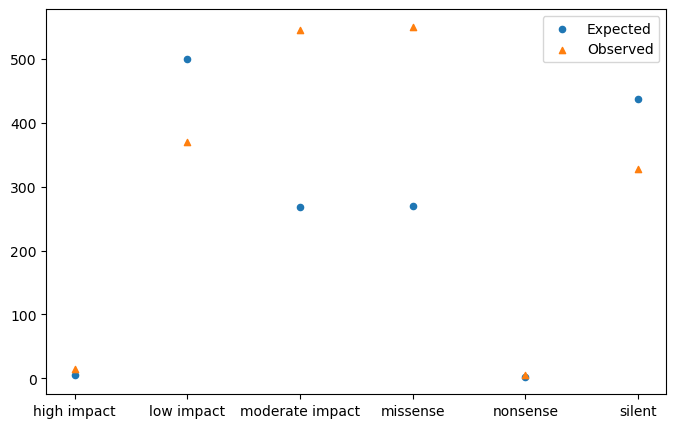

In [ ]:
import matplotlib.pyplot as plt

values_outside
value_labels = ["high impact", "low impact", "moderate impact", "missense", "nonsense", "silent"]
fig = plt.figure(figsize=(8,5))
plt.scatter(list(range(len(value_labels))), expected_values, s = 20, label = "Expected")
plt.scatter(list(range(len(value_labels))), values_inverted, s = 20, label = "Observed", marker = "^")
plt.xticks(list(range(len(value_labels))), value_labels)
plt.legend()
plt.show()

Below are similar between total and inversion:

<img src="2024-10-07-17-09-53.png" width="300"> <img src="2024-10-07-17-10-11.png" width="250">

<img src="2024-10-07-17-11-00.png" width="200"> <img src="2024-10-07-17-11-10.png" width="200">

### Getting allele frequencies

`bcftools view -i 'ANN[*] ~ "HIGH"' test_inv.vcf > high_impact_variants.vcf`
`vcftools --vcf high_impact_variants.vcf --freq --out my_freq_out_file`

Repeat for moderate and low, and background. 

**Above in script get_afs.sh**

In [132]:
import pandas as pd
import os
import matplotlib.pyplot as plt

level = "low"

file_path = os.path.expanduser(f'~/freqs/{level}_impact_freqs_all.txt')
df1 = pd.read_csv(file_path, delimiter='\t')  # Use delimiter='\t' if the file is tab-separated
df1[['ref', 'AF1']] = df1['N_CHR'].str.split(':', expand=True)
df1[['alt', 'AF2']] = df1['{ALLELE:FREQ}'].str.split(':', expand=True)
df1['MAF'] = df1[['AF1', 'AF2']].min(axis=1)
df1['MAF'] = df1['MAF'].astype(float)

file_path = os.path.expanduser(f'~/freqs/{level}_impact_freqs.txt')
df2 = pd.read_csv(file_path, delimiter='\t')
df2[['ref', 'AF1']] = df2['N_CHR'].str.split(':', expand=True)
df2[['alt', 'AF2']] = df2['{ALLELE:FREQ}'].str.split(':', expand=True)
df2['MAF'] = df2[['AF1', 'AF2']].min(axis=1)
df2['MAF'] = df2['MAF'].astype(float)
print(len(df1), len(df2))

df_diff = df1.merge(df2, how='left', indicator=True)

# Keep only the rows that are in df1 but not in df2
df1 = df_diff[df_diff['_merge'] == 'left_only'].drop(columns=['_merge'])
df1

26761 251


,CHROM,POS,N_ALLELES,N_CHR,{ALLELE:FREQ},ref,AF1,alt,AF2,MAF
0,301661,2,234,T:0.884615,A:0.115385,T,0.884615,A,0.115385,0.115385
1,368639,2,260,T:0.773077,G:0.226923,T,0.773077,G,0.226923,0.226923
2,368669,2,262,G:0.801527,A:0.198473,G,0.801527,A,0.198473,0.198473
3,368678,2,260,T:0.8,C:0.2,T,0.8,C,0.2,0.200000
4,368750,2,260,T:0.334615,C:0.665385,T,0.334615,C,0.665385,0.334615
...,...,...,...,...,...,...,...,...,...,...
26756,52838226,2,254,C:0.826772,A:0.173228,C,0.826772,A,0.173228,0.173228
26757,52838413,2,258,G:0.802326,A:0.197674,G,0.802326,A,0.197674,0.197674
26758,52838415,2,260,A:0.946154,G:0.0538462,A,0.946154,G,0.0538462,0.053846
26759,52839569,2,264,T:0.924242,C:0.0757576,T,0.924242,C,0.0757576,0.075758


In [139]:
#percentage of snps high impact and between MAF brakets
#inversion_snps, total_outside
def get_counts(level, mytype):

    file_path = os.path.expanduser(f'~/freqs/{level}_impact_freqs_all.txt')
    df1 = pd.read_csv(file_path, delimiter='\t')  # Use delimiter='\t' if the file is tab-separated
    df1[['ref', 'AF1']] = df1['N_CHR'].str.split(':', expand=True)
    df1[['alt', 'AF2']] = df1['{ALLELE:FREQ}'].str.split(':', expand=True)
    df1['MAF'] = df1[['AF1', 'AF2']].min(axis=1)
    df1['MAF'] = df1['MAF'].astype(float)

    file_path = os.path.expanduser(f'~/freqs/{level}_impact_freqs.txt')
    df2 = pd.read_csv(file_path, delimiter='\t')
    df2[['ref', 'AF1']] = df2['N_CHR'].str.split(':', expand=True)
    df2[['alt', 'AF2']] = df2['{ALLELE:FREQ}'].str.split(':', expand=True)
    df2['MAF'] = df2[['AF1', 'AF2']].min(axis=1)
    df2['MAF'] = df2['MAF'].astype(float)
    #print(len(df1), len(df2))

    df_diff = df1.merge(df2, how='left', indicator=True)
    df1 = df_diff[df_diff['_merge'] == 'left_only'].drop(columns=['_merge'])

    counts = []
    if mytype == "all":
        counts.append(len(df1[df1["MAF"]<0.1]))
        counts.append(len(df1[(df1["MAF"]<0.2) & (df1["MAF"]>=0.1)]))
        counts.append(len(df1[(df1["MAF"]<0.3) & (df1["MAF"]>=0.2)]))
        counts.append(len(df1[(df1["MAF"]<0.4) & (df1["MAF"]>=0.3)]))
        counts.append(len(df1[(df1["MAF"]<0.5) & (df1["MAF"]>=0.4)]))
    else:
        counts.append(len(df2[df2["MAF"]<0.1]))
        counts.append(len(df2[(df2["MAF"]<0.2) & (df2["MAF"]>=0.1)]))
        counts.append(len(df2[(df2["MAF"]<0.3) & (df2["MAF"]>=0.2)]))
        counts.append(len(df2[(df2["MAF"]<0.4) & (df2["MAF"]>=0.3)]))
        counts.append(len(df2[(df2["MAF"]<0.5) & (df2["MAF"]>=0.4)]))

    return counts

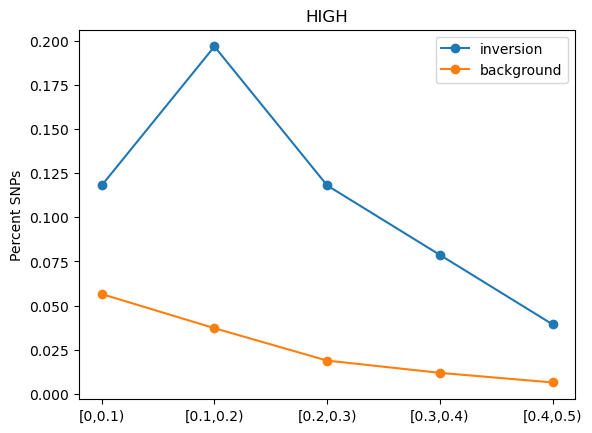

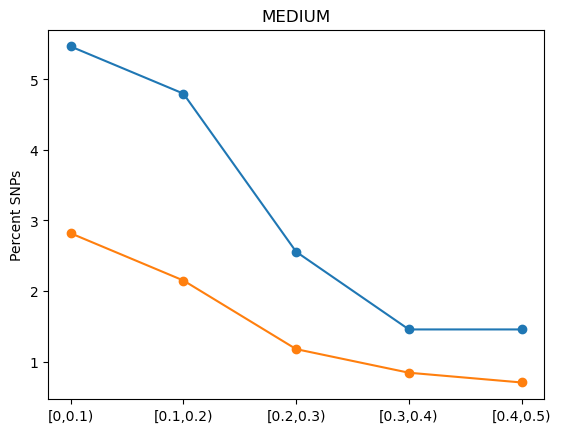

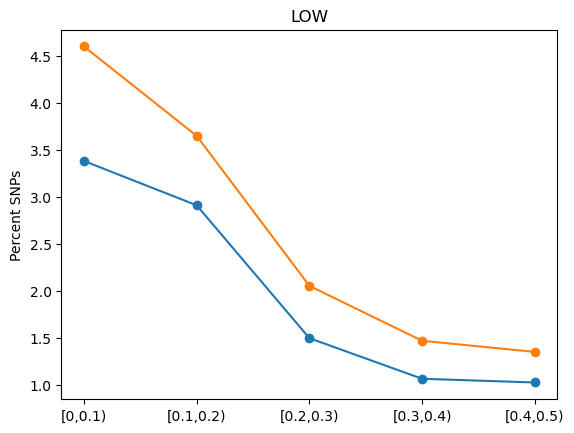

In [145]:
import numpy as np

high_inv = get_counts("high", "inv")
medium_inv = get_counts("medium", "inv")
low_inv = get_counts("low", "inv")
high_out = get_counts("high", "all")
medium_out = get_counts("medium", "all")
low_out = get_counts("low", "all")

value_labels = ["[0,0.1)","[0.1,0.2)","[0.2,0.3)","[0.3,0.4)","[0.4,0.5)"]

plt.plot(list(range(len(high_inv))),np.array(high_inv)/inversion_snps*100, marker="o",label="inversion")
plt.plot(list(range(len(high_inv))),np.array(high_out)/total_outside*100, marker="o",label="background")
plt.xticks(list(range(len(high_inv))), value_labels)
plt.title("HIGH")
plt.ylabel("Percent SNPs")
plt.legend()
plt.show()
plt.plot(list(range(len(high_inv))),np.array(medium_inv)/inversion_snps*100, marker="o",label="inversion")
plt.plot(list(range(len(high_inv))),np.array(medium_out)/total_outside*100, marker="o",label="background")
plt.xticks(list(range(len(high_inv))), value_labels)
plt.title("MEDIUM")
plt.ylabel("Percent SNPs")
plt.show()
plt.plot(list(range(len(high_inv))),np.array(low_inv)/inversion_snps*100, marker="o",label="inversion")
plt.plot(list(range(len(high_inv))),np.array(low_out)/total_outside*100, marker="o",label="background")
plt.xticks(list(range(len(high_inv))), value_labels)
plt.title("LOW")
plt.ylabel("Percent SNPs")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


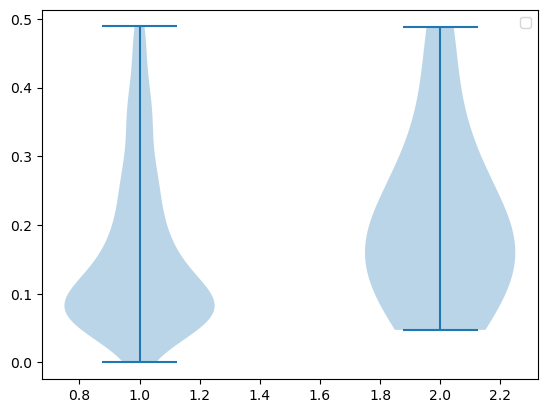

In [82]:
#plt.scatter(list(range(len(df1["MAF"].tolist()))), sorted(df1["MAF"].tolist()), label="all")
#plt.scatter(list(range(len(df2["MAF"].tolist()))), sorted(df2["MAF"].tolist()), label="all")
#plt.boxplot([df1["MAF"].tolist(), df2["MAF"].tolist()], labels=['all', 'inversion'])
plt.violinplot([df1["MAF"].tolist(), df2["MAF"].tolist()])
plt.legend()

In [63]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(df1["MAF"].tolist(), df2["MAF"].tolist(), alternative='less')
p_value

0.47915146389379265

In [75]:
import pandas as pd

levels = ["low","medium", "high"]

df_all = pd.DataFrame()
for l in levels:
    file_path = os.path.expanduser(f'~/freqs/{l}_impact_freqs_all.txt')
    df1 = pd.read_csv(file_path, delimiter='\t')  # Use delimiter='\t' if the file is tab-separated
    df1[['ref', 'AF1']] = df1['N_CHR'].str.split(':', expand=True)
    df1[['alt', 'AF2']] = df1['{ALLELE:FREQ}'].str.split(':', expand=True)
    df1['MAF'] = df1[['AF1', 'AF2']].min(axis=1)
    df1['MAF'] = df1['MAF'].astype(float)
    df_all = pd.concat([df_all, df1], ignore_index=True)

df_inv = pd.DataFrame()
for l in levels:
    file_path = os.path.expanduser(f'~/freqs/{l}_impact_freqs.txt')
    df1 = pd.read_csv(file_path, delimiter='\t')  # Use delimiter='\t' if the file is tab-separated
    df1[['ref', 'AF1']] = df1['N_CHR'].str.split(':', expand=True)
    df1[['alt', 'AF2']] = df1['{ALLELE:FREQ}'].str.split(':', expand=True)
    df1['MAF'] = df1[['AF1', 'AF2']].min(axis=1)
    df1['MAF'] = df1['MAF'].astype(float)
    df_inv = pd.concat([df_inv, df1], ignore_index=True)


0.5886467167548073

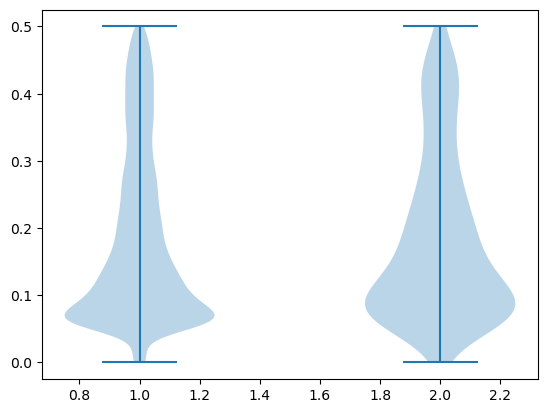

In [144]:
plt.violinplot([df_all["MAF"].tolist(), df_inv["MAF"].tolist()])
stat, p_value = mannwhitneyu(df_all["MAF"].tolist(), df_inv["MAF"].tolist(), alternative='two-sided')
p_value

### Conclusion:
no difference in allele frequencies between outside and inside inversion among low/med/high categories. Nor there is a difference combined.


In [90]:
file_path = os.path.expanduser(f'~/freqs/high_impact_freqs.txt')
df1 = pd.read_csv(file_path, delimiter='\t')  # Use delimiter='\t' if the file is tab-separated
df1[['ref', 'AF1']] = df1['N_CHR'].str.split(':', expand=True)
df1[['alt', 'AF2']] = df1['{ALLELE:FREQ}'].str.split(':', expand=True)
df1['MAF'] = df1[['AF1', 'AF2']].min(axis=1)
df1['MAF'] = df1['MAF'].astype(float)
df1.sort_values(by="MAF")

,CHROM,POS,N_ALLELES,N_CHR,{ALLELE:FREQ},ref,AF1,alt,AF2,MAF
AAGJ06000001.1,13465222,2,274,A:0.0474453,G:0.952555,A,0.0474453,G,0.952555,0.047445
AAGJ06000001.1,12927922,2,262,C:0.931298,T:0.0687023,C,0.931298,T,0.0687023,0.068702
AAGJ06000001.1,16257094,2,244,T:0.92623,C:0.0737705,T,0.92623,C,0.0737705,0.073771
AAGJ06000001.1,13969575,2,242,T:0.867769,A:0.132231,T,0.867769,A,0.132231,0.132231
AAGJ06000001.1,14821340,2,264,A:0.867424,G:0.132576,A,0.867424,G,0.132576,0.132576
AAGJ06000001.1,12925492,2,272,T:0.841912,A:0.158088,T,0.841912,A,0.158088,0.158088
AAGJ06000001.1,13780387,2,266,G:0.823308,A:0.176692,G,0.823308,A,0.176692,0.176692
AAGJ06000001.1,13780732,2,258,G:0.821705,A:0.178295,G,0.821705,A,0.178295,0.178295
AAGJ06000001.1,16395259,2,260,C:0.788462,A:0.211538,C,0.788462,A,0.211538,0.211538
AAGJ06000001.1,12768338,2,270,C:0.777778,G:0.222222,C,0.777778,G,0.222222,0.222222


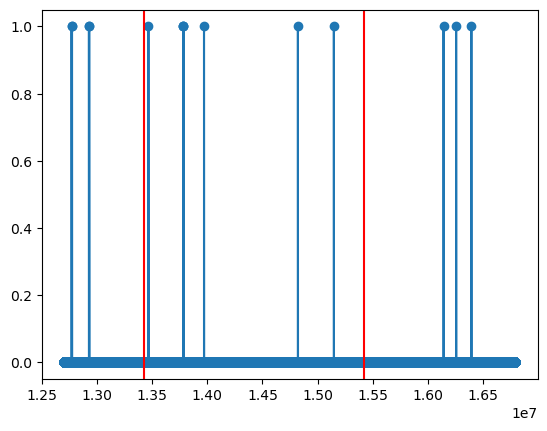

In [89]:
#first spike: 12702886 - 13424367, second spike: 15422748-16793794
#plt.scatter(list(range(len(df1['CHROM'].to_list()))),df1['CHROM'].to_list())
y_values = [1 if x in df1['CHROM'].to_list() else 0 for x in list(range(12702886,16793794))]
plt.plot(list(range(12702886,16793794)),y_values, marker='o')
plt.axvline(13424367, color = "red")
plt.axvline(15422748, color = "red")

None of the high impact mutations fell in interesting/mel_biomin genes. All uncharacterized.

In [154]:
file_path = os.path.expanduser(f'~/pcangsd_combinedposres.csv')
pcdf = pd.read_csv(file_path, delimiter='\t', names = ["A","B"])
pcdf[['chr', 'pos']] = pcdf['A'].str.split('.1_', expand=True)
pcdf[['num', 'y']] = pcdf['B'].str.split(',', expand=True)
pcdf

,A,B,chr,pos,num,y
0,NW_022144952.1_67842,"1,0.00599231112060117",NW_022144952,67842,1,0.00599231112060117
1,NW_022144952.1_67867,"2,0.473750432777181",NW_022144952,67867,2,0.473750432777181
2,NW_022144952.1_67876,"3,0.534564871227556",NW_022144952,67876,3,0.534564871227556
3,NW_022144952.1_67879,"4,0.764002373139761",NW_022144952,67879,4,0.764002373139761
4,NW_022144952.1_67899,"5,0.276074645346306",NW_022144952,67899,5,0.276074645346306
...,...,...,...,...,...,...
2119840,NC_001453.1_15195,"2119841,0.328782496833857",NC_001453,15195,2119841,0.328782496833857
2119841,NC_001453.1_15300,"2119842,0.188347696886111",NC_001453,15300,2119842,0.188347696886111
2119842,NC_001453.1_15324,"2119843,0.82868967446219",NC_001453,15324,2119843,0.82868967446219
2119843,NC_001453.1_15330,"2119844,0.154679772465288",NC_001453,15330,2119844,0.154679772465288


In [160]:
pcdf['pos'] = pcdf['pos'].astype(int)
pcdf['y'] = pcdf['y'].astype(float)

posi = pcdf[pcdf["chr"]=="NW_022145594"].pos.to_list()
ys = pcdf[pcdf["chr"]=="NW_022145594"].y.to_list()

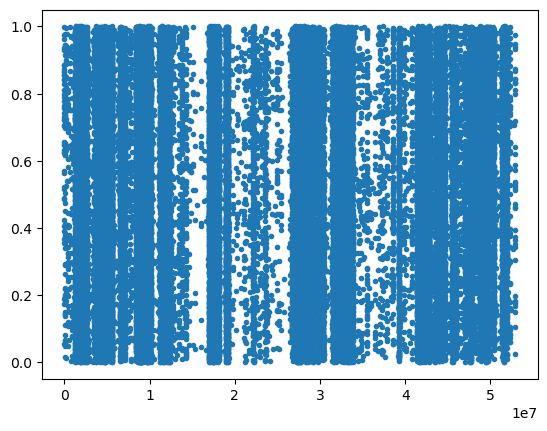

In [161]:
plt.plot(posi, ys, ".")